<a href="https://colab.research.google.com/github/abhinavm24/EIP/blob/master/week5/PersonAttrubutes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/Study/Inkers/resources/hvc_data.zip" -d "."
# look for `hvc_annotations.csv` file and `resized` dir
%ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive/  hvc_annotations.csv  model.png  resized/  sample_data/


In [2]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, Callback


# from keras.applications import VGG16
from keras.layers import Conv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, Input, MaxPooling2D, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state = 42)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [7]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
10416,resized/10418.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
3495,resized/3496.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0
6950,resized/6951.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
5035,resized/5036.jpg,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4410,resized/4411.jpg,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(train_df, batch_size=64, shuffle=False)

In [9]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [10]:
weight_decay = 1e-4
inputs = Input(shape=(224,224,3))

def get_conv_block(num_filters, prev_layer, kernel_size=3, strides=1):
    return BatchNormalization()(Activation('relu')(Conv2D(num_filters,
       kernel_size=kernel_size,
       padding='same',
       strides=strides,
       kernel_regularizer=l2(weight_decay),
       use_bias=False)(prev_layer)))

num_filters = 32
block1 = get_conv_block(num_filters, inputs)
block1 = get_conv_block(num_filters, block1)
block1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(block1)

num_filters = 64
block2 = get_conv_block(num_filters, block1)
block2 = get_conv_block(num_filters, block2)
block2 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(block2)

num_filters = 128
block3 = get_conv_block(num_filters, block2)
block3 = get_conv_block(num_filters, block3)
block3 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(block3)

num_filters = 256
block4 = get_conv_block(num_filters, block3)
block4 = get_conv_block(num_filters, block4)

num_filters = 16
block5 = get_conv_block(num_filters, block4, kernel_size=1)

block6 = GlobalAveragePooling2D()(block5)

neck = block6

def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(8, activation="relu")(neck)
    return neck

def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=inputs, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         activation_1[0][0]               
____________________________________________________________________________________________

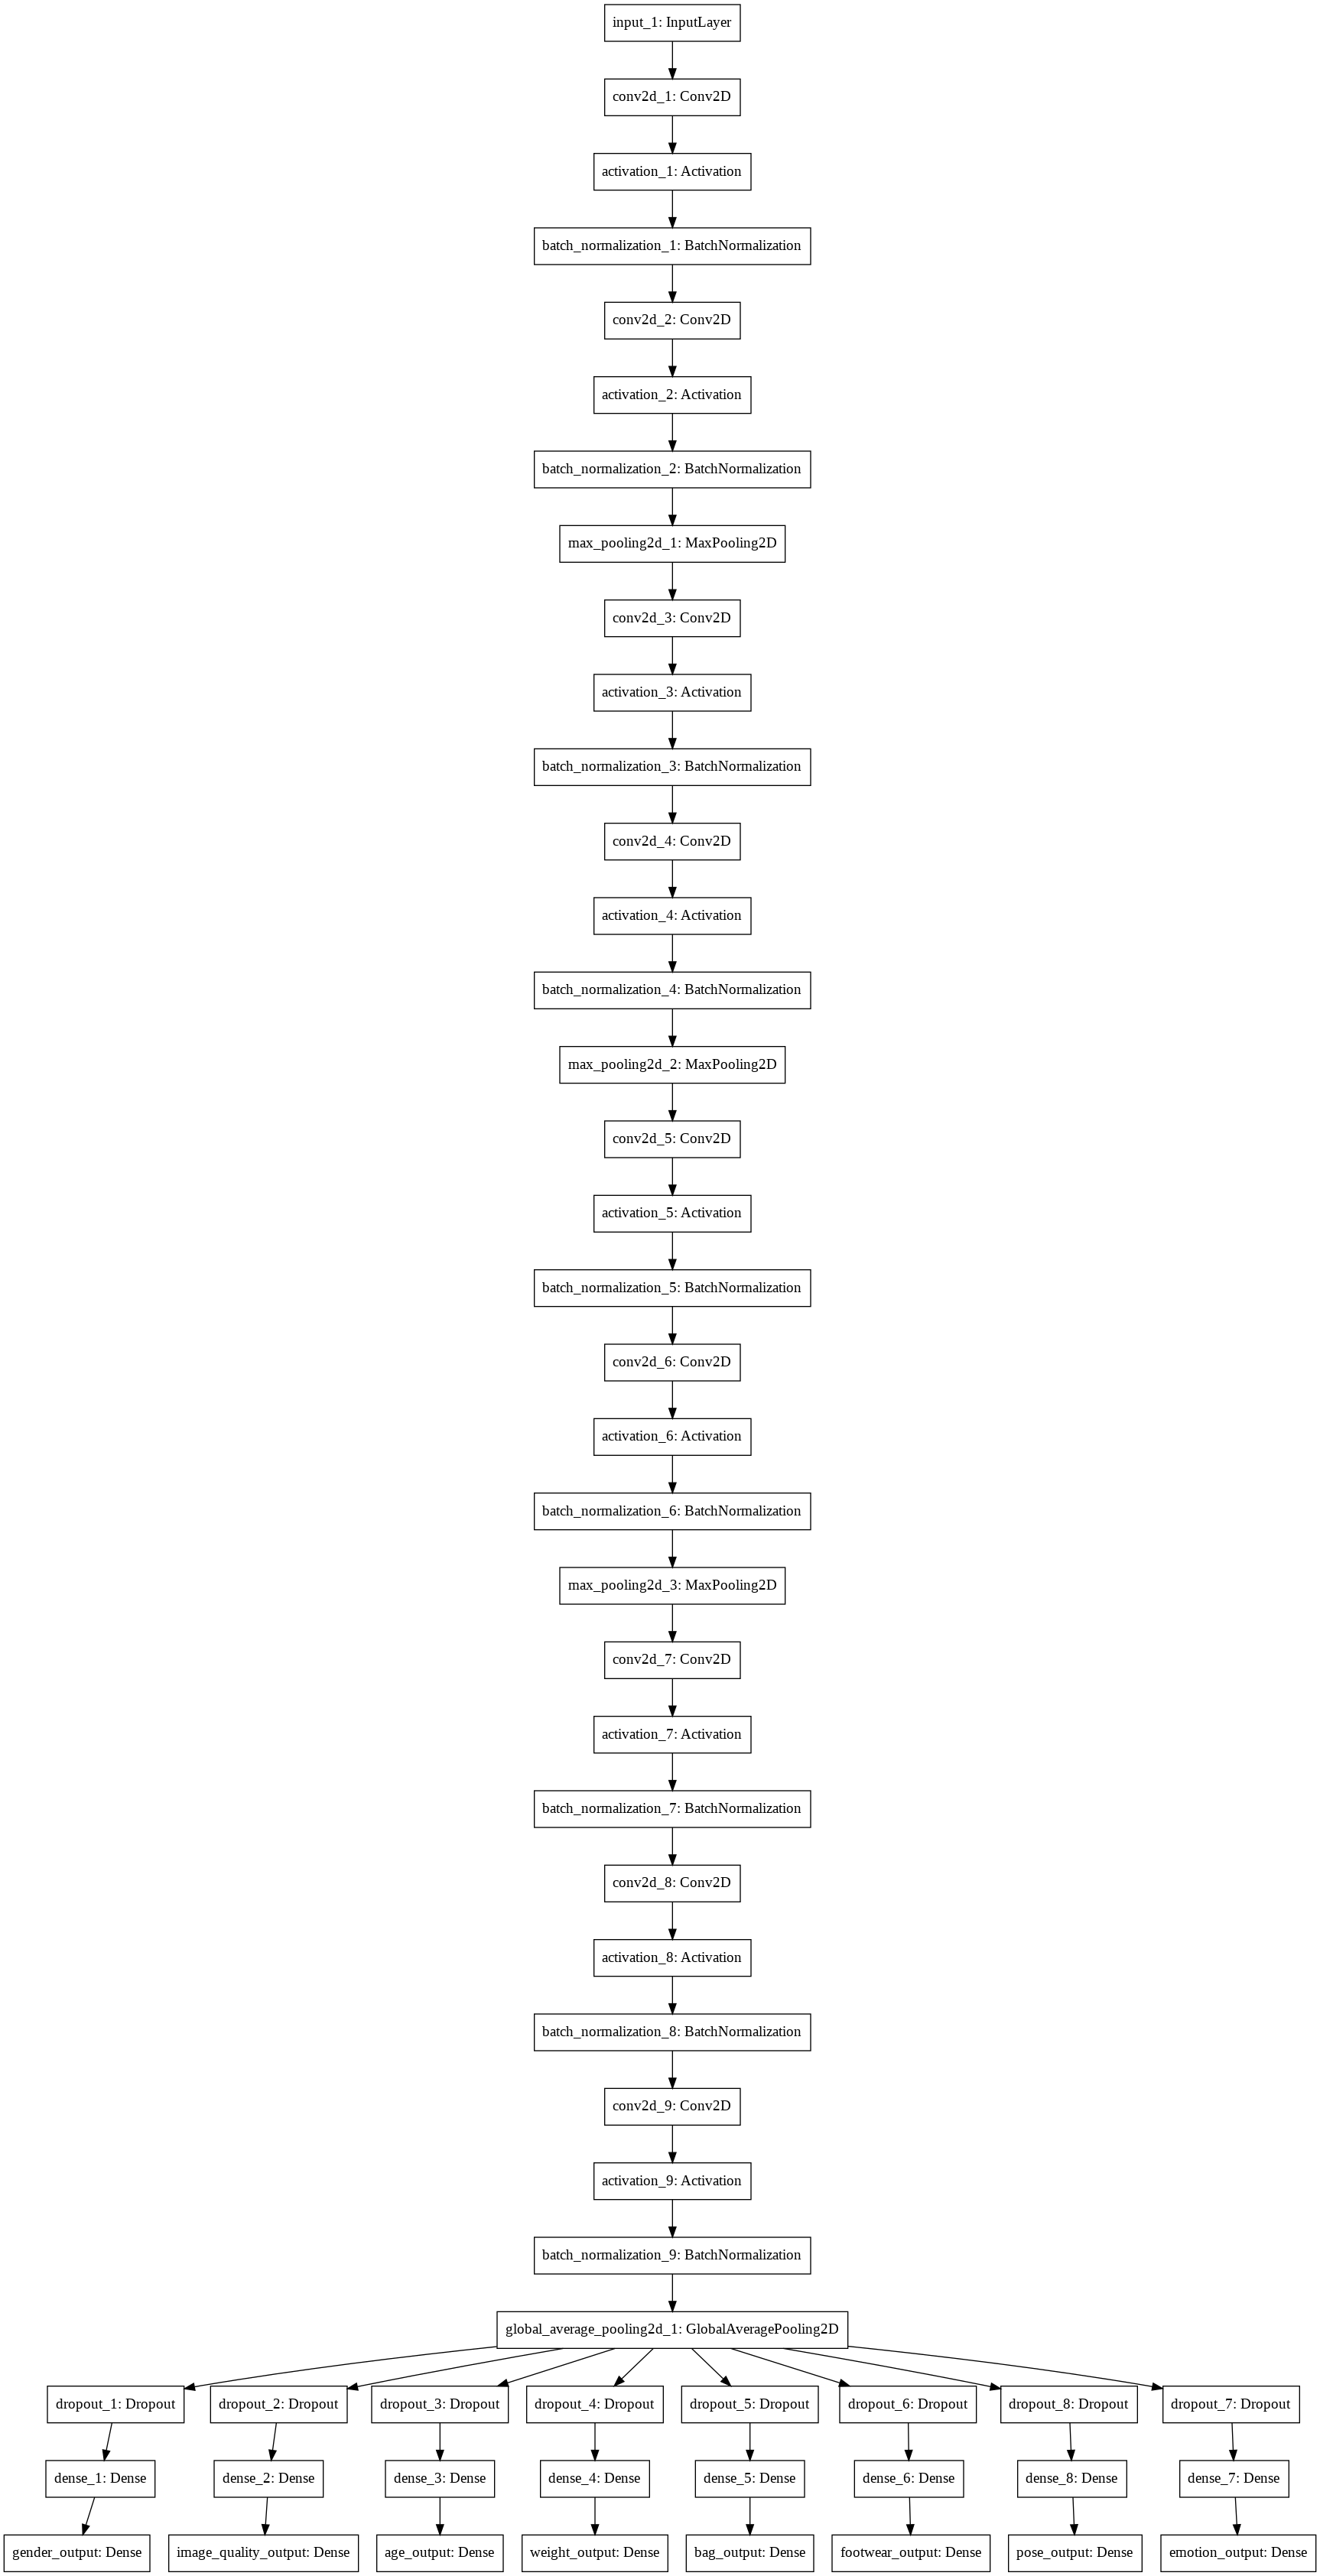

In [12]:
from keras.utils import plot_model
plot_model(model)

In [13]:
def lr_schedule(epoch, lr=1e-3):
    if epoch > 30:
        lr *= 1e-1
    elif epoch > 60:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

model_info = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=8, 
    epochs=100,
    verbose=2
)

Learning rate:  0.001


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
 - 67s - loss: 8.3984 - gender_output_loss: 0.6846 - image_quality_output_loss: 0.9899 - age_output_loss: 1.4890 - weight_output_loss: 1.1164 - bag_output_loss: 0.9740 - footwear_output_loss: 1.0109 - pose_output_loss: 0.9881 - emotion_output_loss: 1.0615 - gender_output_acc: 0.5619 - image_quality_output_acc: 0.5171 - age_output_acc: 0.3851 - weight_output_acc: 0.6065 - bag_output_acc: 0.5357 - footwear_output_acc: 0.5106 - pose_output_acc: 0.5725 - emotion_output_acc: 0.6605 - val_loss: 8.2129 - val_gender_output_loss: 0.7206 - val_image_quality_output_loss: 0.9801 - val_age_output_loss: 1.4563 - val_weight_output_loss: 1.0660 - val_bag_output_loss: 0.9690 - val_footwear_output_loss: 1.0488 - val_pose_output_loss: 0.9611 - val_emotion_output_loss: 0.9298 - val_gender_output_acc: 0.4559 - val_image_quality_output_acc: 0.5199 - val_age_output_acc: 0.4007 -

In [14]:
# Score trained model.
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))

180/180 [==============================] - 18s 99ms/step


{'age_output_acc': 0.7849826388888889,
 'age_output_loss': 0.4906590408749051,
 'bag_output_acc': 0.39774305555555556,
 'bag_output_loss': 3.1354371070861817,
 'emotion_output_acc': 0.7133680555555556,
 'emotion_output_loss': 3.6728229191568165,
 'footwear_output_acc': 0.9558159722222223,
 'footwear_output_loss': 0.11586432482840286,
 'gender_output_acc': 0.8317708333333333,
 'gender_output_loss': 0.5142237515913115,
 'image_quality_output_acc': 0.9578125,
 'image_quality_output_loss': 0.11702320433428717,
 'loss': 13.863075923919677,
 'pose_output_acc': 0.8032986111111111,
 'pose_output_loss': 0.5800851353340679,
 'weight_output_acc': 0.08802083333333334,
 'weight_output_loss': 4.0693300048510235}

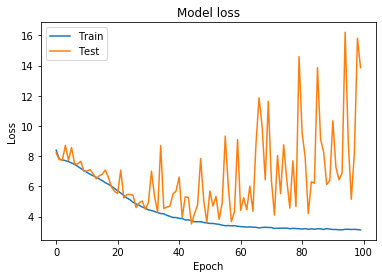

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()